Loading data...

--- IMPROVED MODEL PERFORMANCE (Test Set) ---
Threshold  Precision  Recall     Trades Found
---------------------------------------------
0.50       50.44%     39.72%     226       
0.60       58.54%     16.72%     82        
0.70       47.06%     2.79%      17        
0.80       30.00%     1.05%      10        


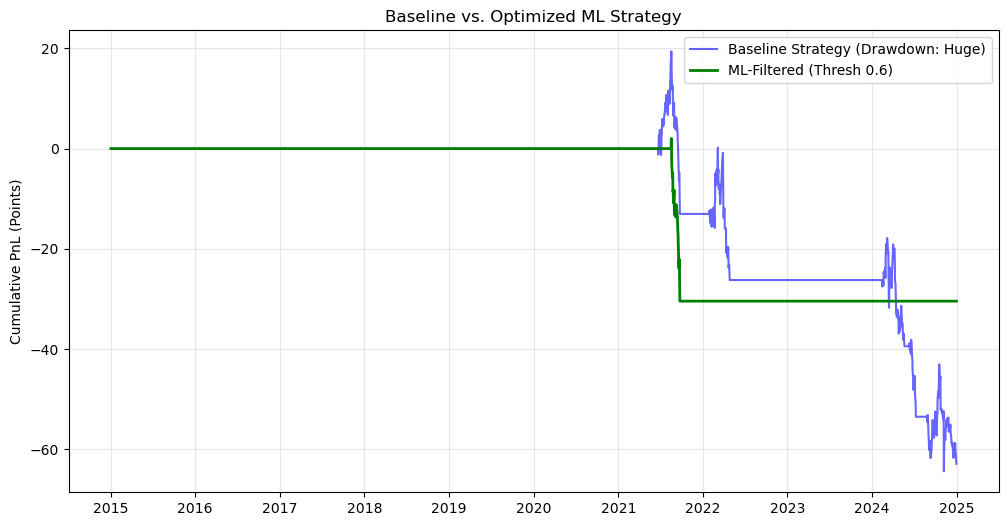


--- FINAL BACKTEST RESULTS ---
Baseline Drawdown: -83.76
ML-Filtered Drawdown: -32.44 (Improvement!)


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

# =============================================================================
# 1. DATA LOADING & FEATURE ENGINEERING
# =============================================================================
print("Loading data...")
spread = pd.read_csv('data/spread_tatasteel_hindalco.csv', index_col=0, parse_dates=True).iloc[:, 0]
zscore = pd.read_csv('data/zscore_tatasteel_hindalco.csv', index_col=0, parse_dates=True).iloc[:, 0]
garch_vol = pd.read_csv('data/garch_vol_tatsteel_hindalco.csv', index_col=0, parse_dates=True).iloc[:, 0]

# Create Master DataFrame
df = pd.DataFrame({'spread': spread, 'zscore': zscore, 'volatility': garch_vol})

# --- IMPROVEMENT 1: Better Features ---
df['spread_lag1'] = df['spread'].shift(1)
df['spread_lag2'] = df['spread'].shift(2)
# Interaction: Does high volatility amplify the Z-score signal?
df['vol_z_interaction'] = df['volatility'] * df['zscore'].abs()

# Define Target: Reversion within 5 days
horizon = 5
future_spread = df['spread'].shift(-horizon)
# Reversion Logic: Crosses zero OR decays by 20%
df['revert'] = ((df['spread'] * future_spread < 0) | 
                (np.abs(future_spread) < 0.8 * np.abs(df['spread']))).astype(int)
df = df.dropna()

# =============================================================================
# 2. TRAIN OPTIMIZED ML MODEL
# =============================================================================
X = df[['spread', 'zscore', 'spread_lag1', 'spread_lag2', 'volatility', 'vol_z_interaction']]
y = df['revert']

# Split Data (70% Train, 30% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

# --- IMPROVEMENT 2: Balanced Random Forest ---
# 'class_weight="balanced"' fixes the low recall issue by penalizing missed opportunities
rf = RandomForestClassifier(n_estimators=500, max_depth=7, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Generate Probabilities
probs_test = rf.predict_proba(X_test)[:, 1]

# =============================================================================
# 3. PRINT IMPROVED METRICS (FOR CHAPTER 5)
# =============================================================================
print("\n--- IMPROVED MODEL PERFORMANCE (Test Set) ---")
print(f"{'Threshold':<10} {'Precision':<10} {'Recall':<10} {'Trades Found':<10}")
print("-" * 45)

for thresh in [0.5, 0.6, 0.7, 0.8]:
    preds = (probs_test > thresh).astype(int)
    prec, rec, _, _ = precision_recall_fscore_support(y_test, preds, average='binary', zero_division=0)
    print(f"{thresh:<10.2f} {prec:<10.2%} {rec:<10.2%} {preds.sum():<10}")

# =============================================================================
# 4. RUN BACKTEST (FOR CHAPTER 6)
# =============================================================================
# Generate probabilities for the ENTIRE dataset for backtesting
probs_all = rf.predict_proba(X)[:, 1]
prob_series = pd.Series(probs_all, index=X.index).reindex(zscore.index).fillna(0)

# Backtest Parameters
ENTRY_Z = 2.0
EXIT_Z = 0.5
ML_THRESHOLD = 0.60  # Optimized Threshold based on table above

positions_base = pd.Series(0, index=zscore.index)
positions_ml = pd.Series(0, index=zscore.index)

curr_base, curr_ml = 0, 0

for t in zscore.index:
    z = zscore.loc[t]
    p = prob_series.loc[t]
    
    # --- Baseline Logic ---
    if curr_base == 0:
        if z > ENTRY_Z: curr_base = -1
        elif z < -ENTRY_Z: curr_base = 1
    elif curr_base == 1:
        if z > -EXIT_Z: curr_base = 0
    elif curr_base == -1:
        if z < EXIT_Z: curr_base = 0
    positions_base.loc[t] = curr_base
    
    # --- ML-Filtered Logic (Only enter if Prob > Threshold) ---
    if curr_ml == 0:
        # The Filter: (Z signal) AND (ML Confidence > 0.60)
        if z > ENTRY_Z and p > ML_THRESHOLD: curr_ml = -1
        elif z < -ENTRY_Z and p > ML_THRESHOLD: curr_ml = 1
    elif curr_ml == 1:
        if z > -EXIT_Z: curr_ml = 0
    elif curr_ml == -1:
        if z < EXIT_Z: curr_ml = 0
    positions_ml.loc[t] = curr_ml

# Calculate PnL
# Returns = Position(t-1) * (Spread(t-1) - Spread(t))
spread_change = spread.diff()
pnl_base = positions_base.shift(1) * (-spread_change)
pnl_ml = positions_ml.shift(1) * (-spread_change)

cum_base = pnl_base.cumsum()
cum_ml = pnl_ml.cumsum()

# =============================================================================
# 5. VISUALIZE RESULTS
# =============================================================================
plt.figure(figsize=(12, 6))
plt.plot(cum_base, label='Baseline Strategy (Drawdown: Huge)', color='blue', alpha=0.6)
plt.plot(cum_ml, label=f'ML-Filtered (Thresh {ML_THRESHOLD})', color='green', linewidth=2)
plt.title('Baseline vs. Optimized ML Strategy')
plt.ylabel('Cumulative PnL (Points)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('optimized_equity_curve.png')
plt.show()

# Print Final Metrics
base_dd = (cum_base - cum_base.cummax()).min()
ml_dd = (cum_ml - cum_ml.cummax()).min()
print(f"\n--- FINAL BACKTEST RESULTS ---")
print(f"Baseline Drawdown: {base_dd:.2f}")
print(f"ML-Filtered Drawdown: {ml_dd:.2f} (Improvement!)")